# Conference Session Scheduling using Graphs

The basic problem: given a large conference with several parallel sessions, how can we schedule sessions in such a way that those of the same topic do not occur in the same time slot? 

Terminology:
* **session $s$**: a single conference session of a given topic
* **time slot $t$**: the date/time at which a session could occur
* **rooms $r$**: the number of available slots for sessions in each time slot

There will be $T$ time slots in the conference and $R$ rooms per time slot, allowing for a total of $S = RT$ sessions to be scheduled. 

The simplest version of the problem is the following: each session has a topic $c$ associated with it. No two sessions with the same topic may be scheduled at the same time. In a less constrained version of the problem, each session may have $n$ different topics $c$ associated with it, in decreasing order of importance. We wish to solve such that sessions who have the same topic at the first position are unlikely to be scheduled at the same time, but that for each topic down the ranked list, the constraint of co-scheduling two sessions with the same two topics at that position becomes increasingly less important.

Either way, we are going to build a graph to solve this problem. For this graph, we take all sessions in $S$ as nodes and draw edges $e$ between all sessions that may co-exist in the same time slot. For the simple version of the problem, the edges will have weight $1$ if the topics are different (i.e. both sessions may coexist in the same time slot) and $0$ otherwise. The problem then reduces to finding closed loops in this graph. 
For a conference with three parallel sessions, we would like to find triangles in this graph (corresponding to three nodes (i.e. sessions) that may all coexist with each other in the same time slot). For conferences with more parallel session, one must choose correspondingly longer paths. 

We can choose an iterative approach to brute-force the selection: 
* find all available triangles and order them in some way
* pick the first triangle, remove from the graph, do the same thing again
* recurse
* if we end up with a solution that leaves no sessions unscheduled, we're done
* if not, back up a step, recurse again, or back up one step further, recurse again

Note: in the strict problem with only one topic, there may be no complete solutions. We probably need to account for that somehow.
In the problem with various topics of different and decreasing importance, we will have multiple edges between nodes, each of which will be one if the edge exists, and different (small) fractions if the edge doesn't exist. Maybe, for the most important topic, it will be zero. For the second, slightly less important topic, it might be 0.1, and so forth. We will multiply all weights together to get a total weight that depends on all topics.
Then, we find all triangles and add up the weights, and order them by weight from largest to smallest. The rest of the procedure follows as before.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import networkx as nx


Let's make a graph:

In [100]:
G=nx.Graph()

Okay, let's start with an example. We are going to have five time slots and three rooms, that gives us a total of fifteen session. We will also have six different session types, and we're going to pick them randomly.

In [101]:
## set the random seed
np.random.seed(20160110)

In [102]:
## make a list of indices
sessions = np.arange(15)

## session topics:
topics = ["exoplanets", "galaxies", "cosmology", "compact_objects", "agn", "stars"]

## randomly select the session labels:
session_labels = np.random.choice(topics, size=sessions.shape[0])

print("all the session labels:" + str(session_labels))

all the session labels:['compact_objects' 'compact_objects' 'agn' 'agn' 'stars' 'cosmology'
 'exoplanets' 'cosmology' 'cosmology' 'compact_objects' 'agn' 'cosmology'
 'cosmology' 'galaxies' 'exoplanets']


Now we can set the nodes of the graph:

In [103]:
for s,l in zip(sessions, session_labels):
    G.add_node(s, topic=l)

In [104]:
G.node[1]["topic"]

'compact_objects'

Now we can also add weights to the edges. We'll add an edge with weight $1$ if the topics are not the same and no weight if the topics are the same:

In [105]:
for i in sessions:
    for j in sessions:
        if session_labels[i] == session_labels[j]:
            continue
        else:
            G.add_edge(i,j,weight=1.0)

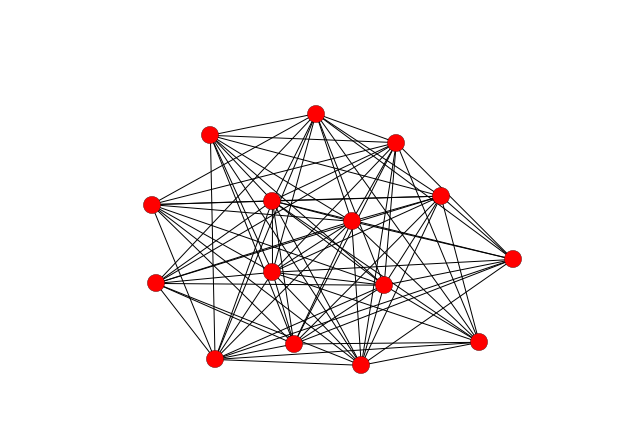

In [106]:
nx.draw(G)

So now that we have the graph, let's solve our first problem: find all triangles:

In [107]:
cliques = list(nx.enumerate_all_cliques(G))

In [108]:
cliques = [c for c in cliques if len(c)==3]
print(cliques)

[[0, 2, 4], [0, 2, 5], [0, 2, 6], [0, 2, 7], [0, 2, 8], [0, 2, 11], [0, 2, 12], [0, 2, 13], [0, 2, 14], [0, 3, 4], [0, 3, 5], [0, 3, 6], [0, 3, 7], [0, 3, 8], [0, 3, 11], [0, 3, 12], [0, 3, 13], [0, 3, 14], [0, 4, 5], [0, 4, 6], [0, 4, 7], [0, 4, 8], [0, 4, 10], [0, 4, 11], [0, 4, 12], [0, 4, 13], [0, 4, 14], [0, 5, 6], [0, 5, 10], [0, 5, 13], [0, 5, 14], [0, 6, 7], [0, 6, 8], [0, 6, 10], [0, 6, 11], [0, 6, 12], [0, 6, 13], [0, 7, 10], [0, 7, 13], [0, 7, 14], [0, 8, 10], [0, 8, 13], [0, 8, 14], [0, 10, 11], [0, 10, 12], [0, 10, 13], [0, 10, 14], [0, 11, 13], [0, 11, 14], [0, 12, 13], [0, 12, 14], [0, 13, 14], [1, 2, 4], [1, 2, 5], [1, 2, 6], [1, 2, 7], [1, 2, 8], [1, 2, 11], [1, 2, 12], [1, 2, 13], [1, 2, 14], [1, 3, 4], [1, 3, 5], [1, 3, 6], [1, 3, 7], [1, 3, 8], [1, 3, 11], [1, 3, 12], [1, 3, 13], [1, 3, 14], [1, 4, 5], [1, 4, 6], [1, 4, 7], [1, 4, 8], [1, 4, 10], [1, 4, 11], [1, 4, 12], [1, 4, 13], [1, 4, 14], [1, 5, 6], [1, 5, 10], [1, 5, 13], [1, 5, 14], [1, 6, 7], [1, 6, 8], [1, 

Awesome, now we can do this recursively:

In [239]:
import copy

def add_edges(G):
    sessions = G.nodes()
    session_labels = [G.node[i]["topic"] for i in G.nodes()]
    nsessions = len(sessions)
    #print(len(sessions))
    #print(len(session_labels))
    for i in xrange(nsessions):
        for j in xrange(nsessions):
            if session_labels[i] == session_labels[j]:
                continue
            else:
                G.add_edge(sessions[i],sessions[j],weight=1.0)
    return G

triangles = []
n_unused = len(sessions)

def recursively_select_triangles(triangles, G, n_unused):

    cliques = list(nx.enumerate_all_cliques(G))
    cliques = [c for c in cliques if len(c)==3]
    ncliques = len(cliques)
    
    if ncliques == 0:
        tnew = triangles.pop(np.random.choice(np.arange(len(triangles))))
        G_new = copy.deepcopy(G)
        for t in tnew:
            G_new.add_node(t[0], topic=t[1])

        G_new = add_edges(G_new)
        n_unused = G_new.number_of_nodes()
        return recursively_select_triangles(triangles, G_new, n_unused)
    
    index = np.random.choice(np.arange(len(cliques)))
    tnew = cliques[index]
    tnew_topics = [G.node[c]["topic"] for c in tnew]
    triangles.append(zip(tnew, tnew_topics))
    G_new = copy.deepcopy(G)
    for n in cliques[index]:
        G_new.remove_node(n)
    
    n_unused = G_new.number_of_nodes()
    
    if n_unused == 0:
        return triangles
    else:
        return recursively_select_triangles(triangles, G_new, n_unused)
        


In [259]:
triangles = []
triangles = recursively_select_triangles(triangles, G, n_unused)

In [260]:
triangles

[[(4, 'stars'), (7, 'cosmology'), (10, 'agn')],
 [(1, 'compact_objects'), (6, 'exoplanets'), (8, 'cosmology')],
 [(2, 'agn'), (12, 'cosmology'), (13, 'galaxies')],
 [(5, 'cosmology'), (9, 'compact_objects'), (14, 'exoplanets')],
 [(0, 'compact_objects'), (3, 'agn'), (11, 'cosmology')]]

Okay, cool! That seems to work in principle. I think I'll probably need some checks and balances in the future, but the basic framework is there. 

Let's clean that up a little:

In [335]:
def add_edges(G, label="topic"):
    sessions = G.nodes()
    session_labels = [G.node[i][label] for i in G.nodes()]
    nsessions = len(sessions)
    for i in xrange(nsessions):
        for j in xrange(nsessions):
            if session_labels[i] == session_labels[j]:
                continue
            else:
                G.add_edge(sessions[i],sessions[j],weight=1.0)
    return G

groups = []
n_unused = len(sessions)
n_counter = 0
def recursively_select_groups(G, groups, n_unused, n_elements, n_counter=0, label="topic"):
    """
    This function recursively splits up the available graph G into 
    cliques of n_elements members. Note: this will probably break if 
    there is no solution, so I should add a check for that!
    
    Parameters
    ----------
    G : networkx.Graph instance
        The graph containing the data (session number, topic)
    
    groups : list of lists
        The list containing all final cliques of the solution
    
    n_unused : int
        A variable counting the number of unused nodes in the graph
        
    n_elements : int
        The number of elements in each clique
    
    label : string, default "topic"
        The label describing each node in the graph
        
    Returns
    -------
    groups: The list containing all final cliques of the solution
    
    """
    n_counter += 1
    
    if n_counter > 200:
        print("No full solution found!")
        remainder = G.nodes()
        return groups, remainder
    
    ## TODO: add assertion that X*n_elements == G.number_of_nodes()
    assert G.number_of_nodes() % np.float(n_elements) == 0, "Number of sessions must be " + \
                                "an integer multiple of n_elements"
    
    ## find all cliques in the graph G
    cliques = list(nx.enumerate_all_cliques(G))
    
    ## find all cliques that have the required number of elements
    cliques = [c for c in cliques if len(c)==n_elements]
    
    ## find the total number of cliques with n_elements members
    ncliques = len(cliques)
    
    ## if there are no cliques, back up a step:
    if ncliques == 0:
        ## pick an already selected clique at random:
        index = np.random.choice(np.arange(len(groups)))
        ## take out the selected group
        tnew = groups.pop(index)
        ## add it back to the graph
        G_new = copy.deepcopy(G)
        for t in tnew:
            G_new.add_node(t[0], topic=t[1])
            
        ## add the edges back to the graph
        G_new = add_edges(G_new)
        
        ## new unused number of nodes
        n_unused = G_new.number_of_nodes()
        ## recurse
        return recursively_select_groups(G_new, groups, n_unused, n_elements, n_counter, label=label)
    
    ## pick a new clique at random:
    index = np.random.choice(np.arange(len(cliques)))
    ## extract the clique number and label
    tnew = cliques[index]
    tnew_topics = [G.node[c]["topic"] for c in tnew]
    
    ## add the new clique to the list of output groups
    groups.append(zip(tnew, tnew_topics))
    G_new = copy.deepcopy(G)
    
    ## remove clique from graph
    for n in cliques[index]:
        G_new.remove_node(n)
    
    ## compute new unused number of nodes
    n_unused = G_new.number_of_nodes()
    
    ## if no unused nodes are left, return the selected groups,
    ## otherwise recurse
    if n_unused == 0:
        remainder = []
        return groups, remainder
    else:
        return recursively_select_groups(G_new, groups, n_unused, n_elements, n_counter, label=label)
        


In [336]:
groups = []
groups, remainder = recursively_select_groups(G, groups, n_unused, n_elements=5, label="topic")

No full solution found!


In [337]:
groups

[[(2, 'agn'),
  (6, 'exoplanets'),
  (9, 'compact_objects'),
  (11, 'cosmology'),
  (13, 'galaxies')],
 [(0, 'compact_objects'),
  (3, 'agn'),
  (4, 'stars'),
  (7, 'cosmology'),
  (14, 'exoplanets')]]

### Searching for groups with proper back-tracking

In order to find the solution, I should probably do the backtracking properly.

Also, I'm going to need a version of `add_edges` that works with a variable number of labels.
Let's do that first:

In [411]:
def add_edges(G, labels, minweight=0.1, maxweight=0.9):
    
    ## find the total number of labels
    nlabels = len(labels)
    print(nlabels)

    ## get a list of lists of all session labels
    session_labels = []
    for l in labels:
        session_labels.append([G.node[i][l] for i in G.nodes()])
    
    ## the total number of sessions
    nsessions = len(sessions)
    
    ## weights for the different attributes
    weights = np.linspace(minweight, maxweight, nlabels-1)
    
    ## iterate over all the different possible labels 
    for i, sl in enumerate(session_labels):
        ## iterate over all nodes
        for k in xrange(nsessions):
            for l in xrange(nsessions):
                ## if sessions have the same label, 
                ## either make no node (for first label), 
                ## or weaken a node that's already there
                if sl[k] == sl[l]:
                    if i == 0 or G.node[k][labels[0]] == G.node[l][labels[0]]:
                        continue
                    else:
                        G[k][l]["weight"] *= weights[i-1]
                else:
                    if i == 0:
                        G.add_edge(sessions[k],sessions[l],weight=1.0)
                    else:
                        continue
    return G



In [412]:
G.remove_edges_from(G.edges())

In [413]:
G = add_edges(G, labels=["topic", "topic2"])

2
weights: [ 0.1]


In [414]:
G.nodes(data=True)

[(0, {'topic': 'compact_objects', 'topic2': 'galaxies'}),
 (1, {'topic': 'compact_objects', 'topic2': 'cosmology'}),
 (2, {'topic': 'agn', 'topic2': 'stars'}),
 (3, {'topic': 'agn', 'topic2': 'stars'}),
 (4, {'topic': 'stars', 'topic2': 'stars'}),
 (5, {'topic': 'cosmology', 'topic2': 'agn'}),
 (6, {'topic': 'exoplanets', 'topic2': 'cosmology'}),
 (7, {'topic': 'cosmology', 'topic2': 'compact_objects'}),
 (8, {'topic': 'cosmology', 'topic2': 'cosmology'}),
 (9, {'topic': 'compact_objects', 'topic2': 'galaxies'}),
 (10, {'topic': 'agn', 'topic2': 'cosmology'}),
 (11, {'topic': 'cosmology', 'topic2': 'exoplanets'}),
 (12, {'topic': 'cosmology', 'topic2': 'exoplanets'}),
 (13, {'topic': 'galaxies', 'topic2': 'exoplanets'}),
 (14, {'topic': 'exoplanets', 'topic2': 'exoplanets'})]

In [415]:
for n,nbrs in G.adjacency_iter():
    for nbr,eattr in nbrs.items():
        data=eattr['weight']
        print('(%d, %d, %.3f, %s, %s)' % (n,nbr,data,G.node[n]["topic2"], G.node[nbr]["topic2"]))

(0, 2, 1.000, galaxies, stars)
(0, 3, 1.000, galaxies, stars)
(0, 4, 1.000, galaxies, stars)
(0, 5, 1.000, galaxies, agn)
(0, 6, 1.000, galaxies, cosmology)
(0, 7, 1.000, galaxies, compact_objects)
(0, 8, 1.000, galaxies, cosmology)
(0, 10, 1.000, galaxies, cosmology)
(0, 11, 1.000, galaxies, exoplanets)
(0, 12, 1.000, galaxies, exoplanets)
(0, 13, 1.000, galaxies, exoplanets)
(0, 14, 1.000, galaxies, exoplanets)
(1, 2, 1.000, cosmology, stars)
(1, 3, 1.000, cosmology, stars)
(1, 4, 1.000, cosmology, stars)
(1, 5, 1.000, cosmology, agn)
(1, 6, 0.010, cosmology, cosmology)
(1, 7, 1.000, cosmology, compact_objects)
(1, 8, 0.010, cosmology, cosmology)
(1, 10, 0.010, cosmology, cosmology)
(1, 11, 1.000, cosmology, exoplanets)
(1, 12, 1.000, cosmology, exoplanets)
(1, 13, 1.000, cosmology, exoplanets)
(1, 14, 1.000, cosmology, exoplanets)
(2, 0, 1.000, stars, galaxies)
(2, 1, 1.000, stars, cosmology)
(2, 4, 0.010, stars, stars)
(2, 5, 1.000, stars, agn)
(2, 6, 1.000, stars, cosmology)
(2, 7

Cool, that seems to work. Next up is the backtracking:

In [423]:
def find_groups_with_backtracking(G, groups, n_elements, n_unused):

    assert G.number_of_nodes() % np.float(n_elements) == 0, "Number of sessions must be " + \
                                "an integer multiple of n_elements"

    label = "topic" ## quick hack for testing, will take care of labels later!
    
    ## base case
    if n_unused == 0:
        return True
    
    else:
        ## find all cliques in the graph G
        cliques = list(nx.enumerate_all_cliques(G))
    
        ## find all cliques that have the required number of elements
        cliques = [c for c in cliques if len(c)==n_elements]

        ## find the total number of cliques with n_elements members
        ncliques = len(cliques)

        for cl in cliques:
            cl_topics = [G.node[c] for c in cl]
            
            ## add the new clique to the list of output groups
            groups.append(zip(cl, cl_topics))
            G_new = copy.deepcopy(G)
    
            ## remove clique from graph
            for n in cl:
                G_new.remove_node(n)
    
            ## compute new unused number of nodes
            n_unused = G_new.number_of_nodes()
    
            ## if no unused nodes are left, return the selected groups,
            ## otherwise recurse
            if find_groups_with_backtracking(G_new, groups, n_elements, n_unused):
                return True
            
            else:
                groups.pop(-1)
                


In [430]:
groups = []
n_elements = 3
n_unused = G.number_of_nodes()
_ = find_groups_with_backtracking(G, groups, n_elements, n_unused)

In [431]:
groups

[[(0, {'topic': 'compact_objects', 'topic2': 'galaxies'}),
  (2, {'topic': 'agn', 'topic2': 'stars'}),
  (5, {'topic': 'cosmology', 'topic2': 'agn'})],
 [(1, {'topic': 'compact_objects', 'topic2': 'cosmology'}),
  (3, {'topic': 'agn', 'topic2': 'stars'}),
  (7, {'topic': 'cosmology', 'topic2': 'compact_objects'})],
 [(4, {'topic': 'stars', 'topic2': 'stars'}),
  (6, {'topic': 'exoplanets', 'topic2': 'cosmology'}),
  (8, {'topic': 'cosmology', 'topic2': 'cosmology'})],
 [(9, {'topic': 'compact_objects', 'topic2': 'galaxies'}),
  (10, {'topic': 'agn', 'topic2': 'cosmology'}),
  (11, {'topic': 'cosmology', 'topic2': 'exoplanets'})],
 [(12, {'topic': 'cosmology', 'topic2': 'exoplanets'}),
  (13, {'topic': 'galaxies', 'topic2': 'exoplanets'}),
  (14, {'topic': 'exoplanets', 'topic2': 'exoplanets'})]]

## Including multiple topics and weights

Let's try a more complex problem: each session now has two attributes. The first attribute must not clash, but the second might with some weight:

In [338]:
session_labels2 = np.random.choice(topics, size=sessions.shape[0])

In [341]:
for i in xrange(len(session_labels2)):
    G.node[i]["topic2"] = session_labels2[i]

In [356]:
G.nodes(data=True)

[(0, {'topic': 'compact_objects', 'topic2': 'galaxies'}),
 (1, {'topic': 'compact_objects', 'topic2': 'cosmology'}),
 (2, {'topic': 'agn', 'topic2': 'stars'}),
 (3, {'topic': 'agn', 'topic2': 'stars'}),
 (4, {'topic': 'stars', 'topic2': 'stars'}),
 (5, {'topic': 'cosmology', 'topic2': 'agn'}),
 (6, {'topic': 'exoplanets', 'topic2': 'cosmology'}),
 (7, {'topic': 'cosmology', 'topic2': 'compact_objects'}),
 (8, {'topic': 'cosmology', 'topic2': 'cosmology'}),
 (9, {'topic': 'compact_objects', 'topic2': 'galaxies'}),
 (10, {'topic': 'agn', 'topic2': 'cosmology'}),
 (11, {'topic': 'cosmology', 'topic2': 'exoplanets'}),
 (12, {'topic': 'cosmology', 'topic2': 'exoplanets'}),
 (13, {'topic': 'galaxies', 'topic2': 'exoplanets'}),
 (14, {'topic': 'exoplanets', 'topic2': 'exoplanets'})]

We've already changed `add_edges` so it can deal with multiple labels. Now we need to add the weights to the recursion. The weights essentially modify the edges in such a way that cliques with a smaller weight will have less of a chance to be picked:

In [447]:
G[0][2]

{'weight': 1.0}

In [712]:
def _sort_cliques_by_weights(G, cliques, n_elements):
    """
    Sort cliques by their weights.
    
    Parameters
    ----------
    G : networkx.Graph instance
        Undirected graph with nodes and edges.
        Edges must have attribute 'weight'
        
    cliques : iterable
        A list of lists; inner lists must have n_elements members
    
    n_elements : integer
        The number of elements in each clique
        
    Returns
    -------
    cliques : iterable
        All cliques sorted by weights in descending order
        
    summed_weights : iterable
        The list of summed weights, sorted in the 
        same descending order as cliques
    
    """
    ## compute summed weights for all cliques:
    summed_weights = []
    for cl in cliques:
        ww = 0
        for i in xrange(n_elements):
            for j in xrange(n_elements):
                if i >= j:
                    continue
                else:
                    ww += G[cl[i]][cl[j]]["weight"]

        summed_weights.append(ww)

    ## sort cliques from highest weight to smallest
    sorted_cliques = cliques[np.argsort(summed_weights)[::-1]]
    ## sort weights in the same way
    summed_weights = np.sort(summed_weights)[::-1]

    return sorted_cliques, summed_weights



def find_groups_with_weights(G, n_elements, n_unused=None, results=None):
    """
    Sort nodes in G into groups of n_elements members such that 
    the total sum of weights is maximized. 
    If the graph includes hard constraints on the relationship between 
    nodes (i.e. missing edges), it is possible that no solution is found.
    
    In the case of a fully connected graph, the solution will be that 
    which maximizes the weights. The weights are inherent attributes of 
    the Graph and must be calculated beforehand (see `add_edges` for details).
    
    Parameters
    ----------
    G : networkx.Graph() instance
        Undirected graph with nodes and edges. The edges must have weights 
        between 0 and 1, but edges can be missing if no relationship exists 
        between nodes.
        
    groups : iterable
        A list of lists containing all groups of n_elements members fulfilling 
        the connectivity constraints that maximize the sum of weights of all 
        groups being used.
        Should be initialized with an empty list, will be modified during the 
        recursion to be filled with the groups.
        
    n_elements : integer
        The number of elements per group. Must be an integer divisor of the 
        total number of nodes in the graph.
        
    n_unused : integer
        The number of unused nodes in the graph at every recursion step. 
        If None, then it will be initialized as the total number of nodes
        in the graph.
    
    weights_total_sum : list
        The total sum of weights of elements in `groups`. 
        If None, then it will be initialized as an empty list to count 
        the sum of weights for each individual group. Will be summed at 
        the end before output into a float value.
        Note: DO NOT SET THIS AT THE BEGINNING OF THE RUN!
        
    Returns
    -------
    success : bool
        Flag indicating success or failure of the algorithm
        
    groups: iterable
        A list of lists containing all groups of n_elements members fulfilling 
        the connectivity constraints that maximize the sum of weights of all 
        groups being used.        
        
    weights_total_sum : float
        The total sum of all weights of the output groups
    
    """
    assert G.number_of_nodes() % np.float(n_elements) == 0, "Number of sessions must be " + \
                                "an integer multiple of n_elements"

    ## if weights_total_sum isn't set, initialize empty list
    if weights_total_sum is None:
        weights_total_sum = []
        
    if n_unused is None:
        n_unused = G.number_of_nodes()

    ## base case
    if n_unused == 0:
        return True, groups, np.sum(weights_total_sum)

    ## recursion
    else:
        ## find all cliques in the graph G
        cliques = list(nx.enumerate_all_cliques(G))
    
        ## find all cliques that have the required number of elements
        cliques = np.array([c for c in cliques if len(c)==n_elements])

        ## sort cliques by weights
        cliques, summed_weights = _sort_cliques_by_weights(G, cliques, n_elements)

        ## find the total number of cliques with n_elements members
        ncliques = len(cliques)

        ## loop over all cliques:
        for cl,ww in zip(cliques, summed_weights):

            cl_topics = [G.node[c] for c in cl]
            
            ## add the new clique to the list of output groups
            groups.append(zip(cl, cl_topics))
            
            ## add total weight of the clique:
            weights_total_sum.append(ww)
            
            ## make a new deep copy for the next recursion step
            G_new = copy.deepcopy(G)
    
            ## remove clique from graph
            for n in cl:
                G_new.remove_node(n)
    
            ## compute new unused number of nodes
            n_unused = G_new.number_of_nodes()
    
            ## if no unused nodes are left, return the selected groups,
            ## otherwise recurse
            if find_groups_with_weights(G_new, groups, n_elements, n_unused, weights_total_sum):
                return True, groups, np.sum(weights_total_sum)
            
            ## backtrack
            else:
                groups.pop(-1)
                weights_total_sum.pop(-1)
    #return False, groups, weights_total_sum


In [713]:
groups = []
n_elements = 3
success, groups, weights_total_sum= find_groups_with_weights(G, groups, n_elements)

In [714]:
success

True

In [715]:
groups

[[(2, {'topic': 'agn', 'topic2': 'stars'}),
  (8, {'topic': 'cosmology', 'topic2': 'cosmology'}),
  (14, {'topic': 'exoplanets', 'topic2': 'exoplanets'})],
 [(4, {'topic': 'stars', 'topic2': 'stars'}),
  (5, {'topic': 'cosmology', 'topic2': 'agn'}),
  (13, {'topic': 'galaxies', 'topic2': 'exoplanets'})],
 [(9, {'topic': 'compact_objects', 'topic2': 'galaxies'}),
  (10, {'topic': 'agn', 'topic2': 'cosmology'}),
  (12, {'topic': 'cosmology', 'topic2': 'exoplanets'})],
 [(1, {'topic': 'compact_objects', 'topic2': 'cosmology'}),
  (3, {'topic': 'agn', 'topic2': 'stars'}),
  (11, {'topic': 'cosmology', 'topic2': 'exoplanets'})],
 [(0, {'topic': 'compact_objects', 'topic2': 'galaxies'}),
  (6, {'topic': 'exoplanets', 'topic2': 'cosmology'}),
  (7, {'topic': 'cosmology', 'topic2': 'compact_objects'})]]

In [716]:
weights_total_sum

15.0

Seems to work fine! Let's try a different set of elements:

In [717]:
groups = []
n_elements = 5
success = find_groups_with_weights(G, groups, n_elements, n_unused=G.number_of_nodes())

In [718]:
success

Testing the function with an objective version of the results.

This seems to work! At least it doesn't fail if no solution is found.

In [869]:
class Results(object):
    
    def __init__(self, n_elements):
        self.n_elements = n_elements
        self.groups = []
        self.all_weights = []
        self.success = True
        
    def update_groups(self, groups):
        self.groups.append(groups)
        
    def update_weights(self, weights_sum_total):
        self.all_weights.append(weights_sum_total)
        self.weights_sum_total = np.sum(self.all_weights)

def find_groups_with_weights(G, n_elements, n_unused=None, results=None):
    """
    Sort nodes in G into groups of n_elements members such that 
    the total sum of weights is maximized. 
    If the graph includes hard constraints on the relationship between 
    nodes (i.e. missing edges), it is possible that no solution is found.
    
    In the case of a fully connected graph, the solution will be that 
    which maximizes the weights. The weights are inherent attributes of 
    the Graph and must be calculated beforehand (see `add_edges` for details).
    
    Parameters
    ----------
    G : networkx.Graph() instance
        Undirected graph with nodes and edges. The edges must have weights 
        between 0 and 1, but edges can be missing if no relationship exists 
        between nodes.
        
    groups : iterable
        A list of lists containing all groups of n_elements members fulfilling 
        the connectivity constraints that maximize the sum of weights of all 
        groups being used.
        Should be initialized with an empty list, will be modified during the 
        recursion to be filled with the groups.
        
    n_elements : integer
        The number of elements per group. Must be an integer divisor of the 
        total number of nodes in the graph.
        
    n_unused : integer
        The number of unused nodes in the graph at every recursion step. 
        If None, then it will be initialized as the total number of nodes
        in the graph.
    
    weights_total_sum : list
        The total sum of weights of elements in `groups`. 
        If None, then it will be initialized as an empty list to count 
        the sum of weights for each individual group. Will be summed at 
        the end before output into a float value.
        Note: DO NOT SET THIS AT THE BEGINNING OF THE RUN!
        
    Returns
    -------
    success : bool
        Flag indicating success or failure of the algorithm
        
    groups: iterable
        A list of lists containing all groups of n_elements members fulfilling 
        the connectivity constraints that maximize the sum of weights of all 
        groups being used.        
        
    weights_total_sum : float
        The total sum of all weights of the output groups
    
    """

    assert G.number_of_nodes() % np.float(n_elements) == 0, "Number of sessions must be " + \
                                "an integer multiple of n_elements"

   
    ## initialize results object
    if results is None:
        results = Results(n_elements)
        
    if n_unused is None:
        n_unused = G.number_of_nodes()


    ## base case
    if n_unused == 0:
        results.success = True
        return results

    ## recursion
    else:
        ## find all cliques in the graph G
        cliques = list(nx.enumerate_all_cliques(G))
    
        ## find all cliques that have the required number of elements
        cliques = np.array([c for c in cliques if len(c)==n_elements])

        ## sort cliques by weights
        cliques, summed_weights = _sort_cliques_by_weights(G, cliques, n_elements)

        ## find the total number of cliques with n_elements members
        ncliques = len(cliques)

        ## loop over all cliques:
        for g,(cl,ww) in enumerate(zip(cliques, summed_weights)):
            cl_topics = [G.node[c] for c in cl]
            
            ## add the new clique to the list of output groups
            results.update_groups(zip(cl, cl_topics))
            
            ## add total weight of the clique:
            results.update_weights(ww)
            
            ## make a new deep copy for the next recursion step
            G_new = copy.deepcopy(G)
    
            ## remove clique from graph
            for n in cl:
                G_new.remove_node(n)
    
            ## compute new unused number of nodes
            n_unused = G_new.number_of_nodes()
    
            ## if no unused nodes are left, return the selected groups,
            ## otherwise recurse
            results = find_groups_with_weights(G_new, n_elements, n_unused, results)
            if results is not None:
                if results.success:
                        return results
            
            ## backtrack
            else:
                results.success = False
                results.groups.pop(-1)
                results.all_weights.pop(-1)
                continue
    
    if len(results.groups) == 0:
        print("No solution found!")
        results.success = False
        return results

    else:
        results.groups.pop(-1)
        results.all_weights.pop(-1)

        results.success = False
        return results



In [884]:
G.remove_edges_from(G.edges())
G = add_edges(G, labels=["topic", "topic2"])

2
weights: [ 0.1]


In [885]:
n_elements = 3
results = find_groups_with_weights(G, n_elements)

In [886]:
results.groups

[[(2, {'topic': 'agn', 'topic2': 'stars'}),
  (8, {'topic': 'cosmology', 'topic2': 'cosmology'}),
  (14, {'topic': 'exoplanets', 'topic2': 'exoplanets'})],
 [(4, {'topic': 'stars', 'topic2': 'stars'}),
  (5, {'topic': 'cosmology', 'topic2': 'agn'}),
  (13, {'topic': 'galaxies', 'topic2': 'exoplanets'})],
 [(9, {'topic': 'compact_objects', 'topic2': 'galaxies'}),
  (10, {'topic': 'agn', 'topic2': 'cosmology'}),
  (12, {'topic': 'cosmology', 'topic2': 'exoplanets'})],
 [(1, {'topic': 'compact_objects', 'topic2': 'cosmology'}),
  (3, {'topic': 'agn', 'topic2': 'stars'}),
  (11, {'topic': 'cosmology', 'topic2': 'exoplanets'})],
 [(0, {'topic': 'compact_objects', 'topic2': 'galaxies'}),
  (6, {'topic': 'exoplanets', 'topic2': 'cosmology'}),
  (7, {'topic': 'cosmology', 'topic2': 'compact_objects'})]]

In [887]:
results.weights_sum_total

15.0


### Using soft constraints

At the moment, I have the hard constraint in the model that if the first label is the same for two nodes, there will be *no* edge, which means that any model that can't be completely decomposed into cliques will not have a solution.
Perhaps I ought to have a version without hard constraints? 
This basically includes a change in the `add_edges` function:

In [872]:
def add_edges_no_hard_constraint(G, labels, minweight=0.0, maxweight=0.9):
    
    ## find the total number of labels
    nlabels = len(labels)

    ## get a list of lists of all session labels
    session_labels = []
    for l in labels:
        session_labels.append([G.node[i][l] for i in G.nodes()])
    
    ## the total number of sessions
    nsessions = len(sessions)
    
    ## weights for the different attributes
    weights = np.linspace(minweight, maxweight, nlabels)
    
    print("weights: " + str(weights))
    ## iterate over all the different possible labels 
    for i, sl in enumerate(session_labels):
        ## iterate over all nodes
        for k in xrange(nsessions):
            for l in xrange(nsessions):
                ## if sessions have the same label, 
                ## either make no node (for first label), 
                ## or weaken a node that's already there
                if sl[k] == sl[l]:
                    if i == 0:
                        G.add_edge(sessions[k],sessions[l],weight=weights[0])
                    else:
                        G[k][l]["weight"] *= weights[i]
                else:
                    if i == 0:
                        G.add_edge(sessions[k],sessions[l],weight=1.0)
                    else:
                        continue
    return G




Let's redo the edges on the graph to exclude hard constraints and see what happens to our method:

In [873]:
## remove all edges
G.remove_edges_from(G.edges())

In [874]:
G = add_edges_no_hard_constraint(G, ["topic", "topic2"])

weights: [ 0.   0.9]


In [875]:
G.edges(data=True)

[(0, 0, {'weight': 0.0}),
 (0, 1, {'weight': 0.0}),
 (0, 2, {'weight': 1.0}),
 (0, 3, {'weight': 1.0}),
 (0, 4, {'weight': 1.0}),
 (0, 5, {'weight': 1.0}),
 (0, 6, {'weight': 1.0}),
 (0, 7, {'weight': 1.0}),
 (0, 8, {'weight': 1.0}),
 (0, 9, {'weight': 0.0}),
 (0, 10, {'weight': 1.0}),
 (0, 11, {'weight': 1.0}),
 (0, 12, {'weight': 1.0}),
 (0, 13, {'weight': 1.0}),
 (0, 14, {'weight': 1.0}),
 (1, 1, {'weight': 0.0}),
 (1, 2, {'weight': 1.0}),
 (1, 3, {'weight': 1.0}),
 (1, 4, {'weight': 1.0}),
 (1, 5, {'weight': 1.0}),
 (1, 6, {'weight': 0.81000000000000005}),
 (1, 7, {'weight': 1.0}),
 (1, 8, {'weight': 0.81000000000000005}),
 (1, 9, {'weight': 0.0}),
 (1, 10, {'weight': 0.81000000000000005}),
 (1, 11, {'weight': 1.0}),
 (1, 12, {'weight': 1.0}),
 (1, 13, {'weight': 1.0}),
 (1, 14, {'weight': 1.0}),
 (2, 2, {'weight': 0.0}),
 (2, 3, {'weight': 0.0}),
 (2, 4, {'weight': 0.81000000000000005}),
 (2, 5, {'weight': 1.0}),
 (2, 6, {'weight': 1.0}),
 (2, 7, {'weight': 1.0}),
 (2, 8, {'weight

That looks about right. So let's redo the grouping:

In [876]:
n_elements = 3
results = find_groups_with_weights(G, n_elements)

In [877]:
results.success

True

In [878]:
results.groups

[[(4, {'topic': 'stars', 'topic2': 'stars'}),
  (6, {'topic': 'exoplanets', 'topic2': 'cosmology'}),
  (11, {'topic': 'cosmology', 'topic2': 'exoplanets'})],
 [(3, {'topic': 'agn', 'topic2': 'stars'}),
  (7, {'topic': 'cosmology', 'topic2': 'compact_objects'}),
  (14, {'topic': 'exoplanets', 'topic2': 'exoplanets'})],
 [(2, {'topic': 'agn', 'topic2': 'stars'}),
  (8, {'topic': 'cosmology', 'topic2': 'cosmology'}),
  (13, {'topic': 'galaxies', 'topic2': 'exoplanets'})],
 [(9, {'topic': 'compact_objects', 'topic2': 'galaxies'}),
  (10, {'topic': 'agn', 'topic2': 'cosmology'}),
  (12, {'topic': 'cosmology', 'topic2': 'exoplanets'})],
 [(0, {'topic': 'compact_objects', 'topic2': 'galaxies'}),
  (1, {'topic': 'compact_objects', 'topic2': 'cosmology'}),
  (5, {'topic': 'cosmology', 'topic2': 'agn'})]]

In [880]:
results.all_weights

[3.0, 3.0, 3.0, 3.0, 2.0]

In [879]:
results.weights_sum_total

14.0

When using soft constraints, one might not always end up with the optimal set. This is because there are *no* hard constraints, so the first full path through the tree will be returned as a valid entry. One thing one might do instead is initialize several times and include a random element in the algorithm to break ties. 
We can do that several times, and you're still not guaranteed to get the optimal path, but it should be better. The alternative is to record *all* solutions and then maximize brute-force over all of them. 
That seems like it would take a long time. 